In [2]:
import torch
import numpy as np
import pandas as pd
import xarray as xr
import dask
import os, sys
import glob
import zarr
from joblib import Parallel, delayed
import os
import dask.array as da
import os, sys, time, glob, re

from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from metpy.interpolate import interpolate_to_points

from skopt.sampler import Sobol
from skopt.space import Real

from util import init_zarr_store
from losses import MaskedMSELoss, MaskedRMSELoss, MaskedTVLoss, MaskedCharbonnierLoss, MaskedPSNR, MaskedSSIM

In [ ]:
'''
# Define the search space
space = [
    Real(0.05, 0.4, name='gamma'),
    Real(3.0, 7.0, name='kappa_star')
]
# Generate Sobol samples
sobol = Sobol(skip=0)
n_samples = 128  # You can adjust this
samples = sobol.generate(space, n_samples)

# Convert to DataFrame for convenience
df = pd.DataFrame(samples, columns=['gamma', 'kappa_star'])
print(df)
df.to_csv('Barnes_parameters_Sobol_sequence.csv')
'''

        gamma  kappa_star
0    0.067301    4.816287
1    0.242301    6.816287
2    0.329801    5.816287
3    0.154801    3.816287
4    0.198551    6.316287
..        ...         ...
123  0.201285    3.972537
124  0.157535    6.472537
125  0.332535    4.472537
126  0.245035    5.472537
127  0.070035    3.472537

[128 rows x 2 columns]


In [4]:
var_name = 'i10fg'
test_dates_range = ['2023-01-01T00','2023-12-31T23']
dates = pd.date_range(start=test_dates_range[0], end=test_dates_range[1], freq='h')
yyyymmdd = pd.Series(dates.year*10000 + dates.month*100 + dates.day).unique()
source_zarr_store = f'data/RTMA.zarr'

In [5]:
orography = xr.open_dataset('orography.nc')
RTMA_lat = orography.latitude.values    # Nx, Ny 2D arrays
RTMA_lon = orography.longitude.values   # Nx, Ny 2D arrays
orography = orography.orog.values

mask = xr.open_dataset('mask_2d.nc').mask
mask_tensor = torch.tensor(mask.values.astype(np.float32))

# Initiate the metrics
metrics = {
    'masked_rmse': MaskedRMSELoss(mask_tensor), 
    'masked_psnr': MaskedPSNR(mask_tensor),
    'masked_ssim': MaskedSSIM(mask_tensor),
}

# Load NYSM station data
nysm = pd.read_csv('nysm.csv')
# NYSM station lat/lon
nysm_latlon = np.stack([
    nysm['lat [degrees]'].values,
    (nysm['lon [degrees]'].values + 360) % 360
], axis=-1) # shape: (N, 2)

# Precompute grid KDTree
grid_points = np.stack([RTMA_lat.ravel(), RTMA_lon.ravel()], axis=-1)
tree = cKDTree(grid_points)
# Query the station locations
_, indices_flat = tree.query(nysm_latlon)
# Convert flat indices to 2D (y, x)
y_indices, x_indices = np.unravel_index(indices_flat, orography.shape)

station_mask = np.zeros_like(RTMA_lat, dtype=np.uint8)
station_mask[y_indices, x_indices] = 1  # Set 1 at the station locations

In [6]:
missing_times = xr.open_dataset(f'nan_times_{var_name}.nc').time
# remove duplicates
missing_times = missing_times.drop_duplicates('time')
missing_times = missing_times.sel(time=slice(test_dates_range[0],test_dates_range[1]))
missing_times       # furtunately, only one time instance is missing, that too in si10.

<xarray.DataArray 'time' (time: 0)> Size: 0B
array([], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 0B

- No missing times exist in i10fg.

In [7]:
# Read the saved Barnes parameter combination csv
df = pd.read_csv('Barnes_parameters_Sobol_sequence.csv',index_col=0)
df

,gamma,kappa_star
0,0.067301,4.816287
1,0.242301,6.816287
2,0.329801,5.816287
3,0.154801,3.816287
4,0.198551,6.316287
...,...,...
123,0.201285,3.972537
124,0.157535,6.472537
125,0.332535,4.472537
126,0.245035,5.472537


In [8]:
scores = []
for idx, row in df.iloc[:32].iterrows():
    gamma = row['gamma']
    kappa_star = row['kappa_star']
    print(f"Sample {idx}: gamma={gamma}, kappa_star={kappa_star}")
    
    # Initialize a Zarr store, for each combinations of gamma and kappa_star
    target_zarr_store = f'data/Barnes_interpolated/parameter_combinations/gamma-kappa-{idx}.zarr'
    os.makedirs(os.path.dirname(target_zarr_store), exist_ok=True)
    init_zarr_store(target_zarr_store, dates, var_name)

    chunk_size = 24
    n_jobs = 60  # 2 threads per chunk, parallel across 60 chunks
    ds = xr.open_zarr(source_zarr_store, chunks={'time': chunk_size})[var_name].sel(time=dates)

    # Open Zarr for writing
    zarr_write = zarr.open(target_zarr_store, mode='a')
    zarr_variable = zarr_write[var_name]

    # Interpolation function
    def interpolate_and_write_block(start_idx):
        success = 0
        end_idx = min(start_idx + chunk_size, len(ds.time))
        for t_idx in range(start_idx, end_idx):
            try:
                sample = ds.isel(time=t_idx)
                station_values = sample.values[y_indices, x_indices]
                interp_flat = interpolate_to_points(
                    nysm_latlon, station_values, grid_points, interp_type='barnes',
                    gamma=gamma, kappa_star=kappa_star
                )
                interp = interp_flat.reshape(RTMA_lat.shape).astype(np.float32)
                zarr_variable[t_idx, :, :] = interp
                success += 1
            except Exception as e:
                print(f"Time index {t_idx} failed: {e}")
        return success

    # Parallel execution
    from tqdm import tqdm
    chunk_starts = list(range(0, len(ds.time), chunk_size))
    results = Parallel(n_jobs=n_jobs)(
        delayed(interpolate_and_write_block)(i) for i in tqdm(chunk_starts)
    )

    # Optional: print summary
    total_success = sum(results)
    print(f"Interpolation completed: {total_success}/{len(ds.time)} time steps written.")

    # === Compute the metrics in comparison to the RTMA target data ===
    # the assumption/known thing is that there are no missing instances.
    target_ds = xr.open_zarr(source_zarr_store)[var_name].sel(time=slice(*test_dates_range))
    target_ds = target_ds.drop_sel(time=missing_times)

    interp_ds = xr.open_zarr(target_zarr_store)[var_name].sel(time=slice(*test_dates_range))
    interp_ds = interp_ds.drop_sel(time=missing_times)

    # Convert [T, H, W] -> [B, 1, H, W]
    target_tensor = torch.tensor(target_ds.values, dtype=torch.float32).unsqueeze(1)
    interp_tensor = torch.tensor(interp_ds.values, dtype=torch.float32).unsqueeze(1)
    interp_tensor = interp_tensor.where(~torch.isnan(interp_tensor), 0.0)  # Replace NaNs with 0.0
    station_mask_tensor = torch.tensor(station_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0).expand(len(target_tensor), -1, -1, -1)  # [8760, 1, H, W]

    #print('nan_indices:',nan_indices)
    for key in metrics.keys():
        metric_value = metrics[key](interp_tensor, target_tensor, station_mask_tensor).item()
        print(f'{key}: {metric_value:.4f}')

        # Save the results
        scores.append({
                "idx": idx,
                "gamma": gamma,
                "kappa_star": kappa_star,
                "Metric": key,
                "Value": metric_value
            })

# Convert results to DataFrame
scores_df = pd.DataFrame(scores)
# Save the results to a CSV file
scores_df.to_csv('Barnes_parameter_search.csv', index=False)

Sample 0: gamma=0.0673006837760647, kappa_star=4.816287170124966


100%|██████████| 365/365 [03:45<00:00,  1.62it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.4623
masked_psnr: 32.4298
masked_ssim: 0.9218
Sample 1: gamma=0.2423006837760647, kappa_star=6.816287170124966


100%|██████████| 365/365 [03:44<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3333
masked_psnr: 33.2287
masked_ssim: 0.9331
Sample 2: gamma=0.3298006837760648, kappa_star=5.816287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3329
masked_psnr: 33.2303
masked_ssim: 0.9332
Sample 3: gamma=0.1548006837760647, kappa_star=3.8162871701249657


100%|██████████| 365/365 [03:40<00:00,  1.65it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.4099
masked_psnr: 32.7464
masked_ssim: 0.9272
Sample 4: gamma=0.1985506837760647, kappa_star=6.316287170124966


100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3438
masked_psnr: 33.1620
masked_ssim: 0.9325
Sample 5: gamma=0.3735506837760647, kappa_star=4.316287170124966


100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3337
masked_psnr: 33.2260
masked_ssim: 0.9331
Sample 6: gamma=0.2860506837760648, kappa_star=5.316287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3352
masked_psnr: 33.2169
masked_ssim: 0.9330
Sample 7: gamma=0.1110506837760647, kappa_star=3.3162871701249657


100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.4525
masked_psnr: 32.4884
masked_ssim: 0.9229
Sample 8: gamma=0.1329256837760647, kappa_star=6.066287170124966


100%|██████████| 365/365 [03:45<00:00,  1.62it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3795
masked_psnr: 32.9357
masked_ssim: 0.9298
Sample 9: gamma=0.3079256837760648, kappa_star=4.066287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3439
masked_psnr: 33.1614
masked_ssim: 0.9324
Sample 10: gamma=0.3954256837760648, kappa_star=5.066287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3335
masked_psnr: 33.2259
masked_ssim: 0.9332
Sample 11: gamma=0.2204256837760648, kappa_star=3.0662871701249657


100%|██████████| 365/365 [03:44<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3967
masked_psnr: 32.8281
masked_ssim: 0.9284
Sample 12: gamma=0.1766756837760648, kappa_star=5.566287170124966


100%|██████████| 365/365 [03:44<00:00,  1.62it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3615
masked_psnr: 33.0494
masked_ssim: 0.9312
Sample 13: gamma=0.3516756837760648, kappa_star=3.5662871701249657


100%|██████████| 365/365 [03:45<00:00,  1.62it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3438
masked_psnr: 33.1620
masked_ssim: 0.9325
Sample 14: gamma=0.2641756837760648, kappa_star=6.566287170124966


100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3327
masked_psnr: 33.2321
masked_ssim: 0.9332
Sample 15: gamma=0.0891756837760647, kappa_star=4.566287170124966


100%|██████████| 365/365 [03:45<00:00,  1.62it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.4442
masked_psnr: 32.5382
masked_ssim: 0.9238
Sample 16: gamma=0.1001131837760647, kappa_star=6.691287170124966


100%|██████████| 365/365 [03:46<00:00,  1.61it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3976
masked_psnr: 32.8227
masked_ssim: 0.9283
Sample 17: gamma=0.2751131837760648, kappa_star=4.691287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3422
masked_psnr: 33.1724
masked_ssim: 0.9326
Sample 18: gamma=0.3626131837760648, kappa_star=5.691287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3341
masked_psnr: 33.2216
masked_ssim: 0.9331
Sample 19: gamma=0.1876131837760647, kappa_star=3.6912871701249657


100%|██████████| 365/365 [03:44<00:00,  1.62it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3943
masked_psnr: 32.8430
masked_ssim: 0.9286
Sample 20: gamma=0.2313631837760648, kappa_star=5.191287170124966


100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3465
masked_psnr: 33.1450
masked_ssim: 0.9323
Sample 21: gamma=0.0563631837760647, kappa_star=3.1912871701249657


100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.4977
masked_psnr: 32.2221
masked_ssim: 0.9175
Sample 22: gamma=0.3188631837760647, kappa_star=6.191287170124966


100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3333
masked_psnr: 33.2276
masked_ssim: 0.9332
Sample 23: gamma=0.1438631837760647, kappa_star=4.191287170124966


100%|██████████| 365/365 [03:44<00:00,  1.62it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.4080
masked_psnr: 32.7587
masked_ssim: 0.9273
Sample 24: gamma=0.1219881837760647, kappa_star=5.441287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3985
masked_psnr: 32.8171
masked_ssim: 0.9282
Sample 25: gamma=0.2969881837760648, kappa_star=3.4412871701249657


100%|██████████| 365/365 [03:42<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3583
masked_psnr: 33.0697
masked_ssim: 0.9314
Sample 26: gamma=0.3844881837760648, kappa_star=6.441287170124966


100%|██████████| 365/365 [03:44<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3414
masked_psnr: 33.1730
masked_ssim: 0.9328
Sample 27: gamma=0.2094881837760647, kappa_star=4.441287170124966


100%|██████████| 365/365 [03:43<00:00,  1.64it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3663
masked_psnr: 33.0190
masked_ssim: 0.9308
Sample 28: gamma=0.1657381837760647, kappa_star=5.941287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3614
masked_psnr: 33.0501
masked_ssim: 0.9312
Sample 29: gamma=0.3407381837760648, kappa_star=3.9412871701249657


100%|██████████| 365/365 [03:44<00:00,  1.62it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3401
masked_psnr: 33.1855
masked_ssim: 0.9327
Sample 30: gamma=0.2532381837760648, kappa_star=4.941287170124966


100%|██████████| 365/365 [03:46<00:00,  1.61it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.3440
masked_psnr: 33.1611
masked_ssim: 0.9324
Sample 31: gamma=0.0782381837760647, kappa_star=6.941287170124966


100%|██████████| 365/365 [03:43<00:00,  1.63it/s]


Interpolation completed: 8760/8760 time steps written.
masked_rmse: 1.4181
masked_psnr: 32.6965
masked_ssim: 0.9264


In [13]:
# Ensure the metric names are correct and consistent in your dataframe
rmse_df = scores_df[scores_df['Metric'] == 'masked_rmse']
psnr_df = scores_df[scores_df['Metric'] == 'masked_psnr']
ssim_df = scores_df[scores_df['Metric'] == 'masked_ssim']

# Get the idx for each best condition
best_rmse_idx = rmse_df.loc[rmse_df['Value'].idxmin(), 'idx']
best_psnr_idx = psnr_df.loc[psnr_df['Value'].idxmax(), 'idx']
best_ssim_idx = ssim_df.loc[ssim_df['Value'].idxmax(), 'idx']

print("Best RMSE at idx:", best_rmse_idx)
print("Best PSNR at idx:", best_psnr_idx)
print("Best SSIM at idx:", best_ssim_idx)

# Find if there's a common idx that satisfies all three (optional)
best_common = set([best_rmse_idx, best_psnr_idx, best_ssim_idx])
if len(best_common) == 1:
    print("✅ Common best idx:", best_common.pop())
else:
    print("❌ No single idx optimizes all three metrics.")


Best RMSE at idx: 14
Best PSNR at idx: 14
Best SSIM at idx: 2
❌ No single idx optimizes all three metrics.


In [25]:
scores_df[scores_df['idx'] == 14], scores_df[scores_df['idx'] == 2]

(    idx     gamma  kappa_star       Metric      Value
 42   14  0.264176    6.566287  masked_rmse   1.332732
 43   14  0.264176    6.566287  masked_psnr  33.232075
 44   14  0.264176    6.566287  masked_ssim   0.933182,
    idx     gamma  kappa_star       Metric      Value
 6    2  0.329801    5.816287  masked_rmse   1.332879
 7    2  0.329801    5.816287  masked_psnr  33.230316
 8    2  0.329801    5.816287  masked_ssim   0.933195)

- To me, the values at 14 and 2 are very close. Since RMSE and PSNR are both optimum at 14, we chose the parameter values of this idx.

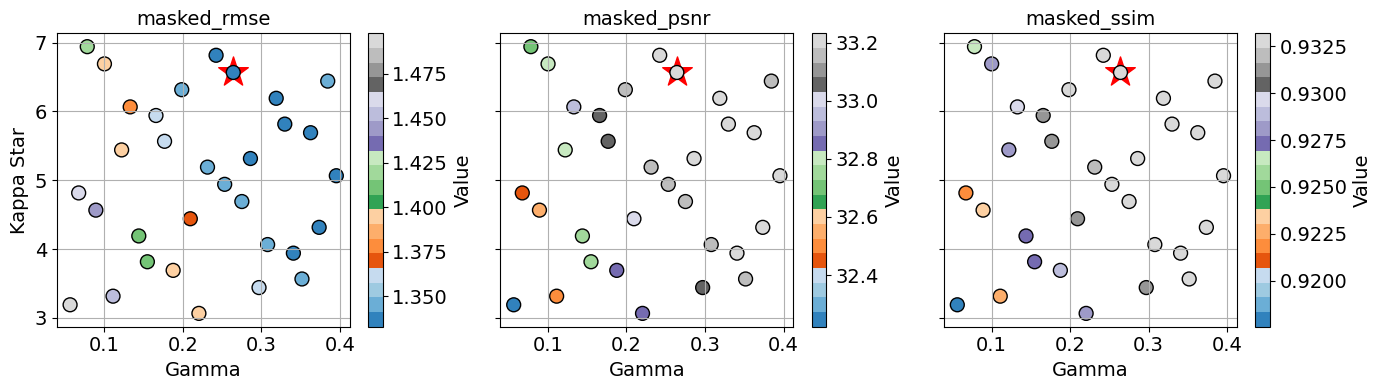

In [47]:
import matplotlib.pyplot as plt

# Group by each metric and plot
metrics = scores_df['Metric'].unique()

# Create a 1x3 subplot
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
fontsize = 14
for i, metric in enumerate(metrics):
    df_metric = scores_df[scores_df['Metric'] == metric]

    ax = axes[i]

    # Mark the 14th idx
    point_14 = df_metric[df_metric['idx'] == 14]
    if not point_14.empty:
        ax.scatter(
            point_14['gamma'], point_14['kappa_star'],
            color='red', marker='*', s=500, label='idx=14'
        )

    scatter = ax.scatter(
        df_metric['gamma'], df_metric['kappa_star'],
        c=df_metric['Value'], cmap='tab20c', s=100, edgecolors='k'
    )
    # Add colorbar for each subplot
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Value', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)

    ax.set_title(f'{metric}')
    ax.set_xlabel('Gamma')
    if i == 0:
        ax.set_ylabel('Kappa Star')
    ax.grid(True)

    ax.set_title(metric, fontsize=fontsize)
    ax.set_xlabel('Gamma', fontsize=fontsize)
    if i == 0:
        ax.set_ylabel('Kappa Star', fontsize=fontsize)

    ax.tick_params(axis='both', labelsize=fontsize)

fig.tight_layout()

plt.savefig(f'Figures/Barnes_parameter_search.pdf',dpi=300,bbox_inches='tight')
